In [366]:
import numpy as np
import random
import math
import collections
import operator
import time
import progressbar

In [367]:
class InvasiveWeed(): # Define class with model name
    def __init__(self, pmax, maxiter, delta_cap, num_exceeded_delta): # Initiate class with required parameters
        seed_array = [] # Initiate empty list to contain tuples of x and y seed coordinates
        for i in range(round(0.2*pmax)): # Initiate 50 seeds with random x and y values between 0 and 10
            x = random.uniform(0, 10) # x = random float between 0 and 10
            y = random.uniform(0, 10) # y = random fload between 0 and 10
            # Append the seed to the seed_array, rounding coordinates to three decimal places
            seed_array.append((round(x, 5),round(y, 5))) 

        self.pmax = pmax
        
        # Initiate delta higher than delta_cap to avoid early iteration stoppage
        delta = delta_cap + 0.01
        
        c = 0 # Initiate int c for num_xceed_delta count
        
        # current_fitness_dict will contain the seed coordinates and their fitness scores
        # for all seeds in our current population (capped to pmax)
        current_fitness_dict = {}
        self.current_fitness_dict = current_fitness_dict
        
        # Initiate list that will contain best fitness score from each iteration
        best_fitness_list =  []
        self.best_fitness_list = best_fitness_list
        
        # Initiate list that will contain best scoring seeds from each iteration
        best_seed_dict = {}
        best_seed_list = []
        self.best_seed_list = best_seed_list
        self.best_seed_dict = best_seed_dict

        # Get the time in seconds to count the runtime of the loop        
        start_time = time.time() 

        
        for i in range(1, maxiter+1): # Iterate n = maxiter times
            fitness_array = self.get_fitness(seed_array) # Get fitness array for current seeds
            fitness_dict = dict(zip(seed_array, fitness_array)) # Make a dictionary containing seed tuple as key and their fitness as values
            
            # Sort seed --> fitness dictionary
            # The lowest scoring fitness value first (the best score)
            sorted_fitness_dict = {k: v for k, v in sorted(fitness_dict.items(), key=lambda item: item[1])} 
            best_seed_dict[list(sorted_fitness_dict.keys())[0]] = list(sorted_fitness_dict.values())[0]
            self.best_seed_dict = best_seed_dict
            
            best_seed_list.append(list(sorted_fitness_dict.values())[0])
            
            # Normalize fitness value in the dictionary
            # Increase the distribution of fitness scores so they start with 0 instead of negative values
            normalized_fitness_dict = self.normalize_fitness(sorted_fitness_dict)
            
            # Compute number of children to be made from each seed
            # and output as a new directory with seed as key and number of children as values
            seed_children_dict = self.eval_fitness(normalized_fitness_dict)
            
            # Append best fitness score to the global fitness_array
            best_fitness_list.append(sorted(fitness_array)[0])
            #print(best_fitness_list,"\n")
            
            # Add seeds and their fitness scores from this iteration to the population (current_fitness_dict)
            for seed, fitness in fitness_dict.items():
                current_fitness_dict[seed] = fitness

            
            # If population is bigger than the set pmax
            # we need to trim it by keeping only best scoring seeds
            if len(current_fitness_dict) > pmax:
                    self.prune_seeds()

            
            # Generate new seeds and add them to current array of seeds
            seed_array = seed_array + self.generate_population(seed_children_dict)

            # After 5 iterations,
            # Start checking whether the delta (difference between last and second last fitness scores)
            # is higher than the cap on the score difference set by the user as delta_cap
            if len(best_seed_dict) > 5:
                # Subtract best fitness from the last two iterations 
                delta = best_fitness_list[-1] - best_fitness_list[-2]
            else:
                # Before 5 iterations the fitness has been very variable and could produce an error with a 0 delta
                # we avoid it by adding 0.01 to the delta to avoid this
                delta = delta_cap + 0.01
            
            # If delta is lower than the delta_cap set bby user
            # add to the counter for threshold of num_exceeded_data
            if delta < delta_cap:
                c += 1

            # Break the function if the delta has been lower than the delta_cap
            # more than the num_exceeded_data set by the user
            if c == num_exceeded_delta:
                break
                
            self.i = i # Keep track of the last iteration

            

        end_time = time.time() # Get time in seconds
        runtime = end_time - start_time # Get runtime of the model
        self.runtime = runtime # Make runtime accessable inside the class
    
        
    def generate_population(self,seed_children_dict):
        new_seeds = []
        for seed, nchildren in seed_children_dict.items():
            for _ in range(nchildren):
                x = seed[0]
                y = seed[1]
                new_x = random.gauss(x,1)
                new_y = random.gauss(y,1)

                while new_x < 0 or new_x > 10:
                    new_x=random.gauss(x,1)

                while new_y < 0 or new_y > 10:
                    new_y=random.gauss(y,1)

                new_seeds.append((new_x, new_y))

        return new_seeds
    
    def get_fitness(self,seed_array):
        fitness_array = []
        for seed in seed_array:
            x = seed[0]
            y = seed[1]
            fitness = ( x * math.sin(4*x) ) + ( 1.1 * y * math.sin( 2 * y) )
            fitness_array.append(fitness)
            
        return fitness_array
    
    def normalize_fitness(self,sorted_fitness_dict):
        lowest_fitness_element = list(sorted_fitness_dict.items())[0]
        if lowest_fitness_element:
            new_vals = []
            for val in sorted_fitness_dict.values():
                new_val = val - list(sorted_fitness_dict.values())[0]
                new_vals.append(new_val)
            sorted_fitness_dict = dict(zip(sorted_fitness_dict.keys(), new_vals))
        
        self.lowest_fitness_element = lowest_fitness_element
        return sorted_fitness_dict

    def eval_fitness(self,normalized_fitness_dict):
        children_seed_list = []
        maximum = max(normalized_fitness_dict.values())
        for val in normalized_fitness_dict.values():
            num_seed = round( ( (val+0.000001) ) / maximum)
            children_seed_list.append(num_seed)

        seed_children_dict = dict(zip(normalized_fitness_dict.keys(), children_seed_list[::-1]))

        return seed_children_dict

    def get_new_seed_count(self,seed_children_dict):
        new_seeds_count = 0
        for seed, children in seed_children_dict.items():
            for i in range(children):
                new_seeds_count += children

        return new_seeds_count
    
    def prune_seeds(self):
        sorted_current_fitness_dict = {k: v for k, v in sorted(self.current_fitness_dict.items(), key=lambda item: item[1])}
        self.current_fitness_dict = dict(list(sorted_current_fitness_dict.items())[0:self.pmax]) 
    
    def return_best_iteration_(self):
        return self.i
    
    def return_runtime_(self):
        return self.runtime
    
    def return_best_seed_(self):
        best_seed_dict = {k: v for k, v in sorted(self.best_seed_dict.items(), key=lambda item: item[1])}
        return list(min(best_seed_dict.items(), key=lambda x: x[1]))
    
    def return_best_fitness_(self):
        return list(self.best_seed_list)
    

In [368]:
def grid_search(params):
    c = 0
    grid_search_dict = {}
    runtimes = []
    param_no = np.prod([len(x) for x in params.values()])
    total = progressbar.ProgressBar(maxval=param_no)
    total.start()
    best_seeds = []
    for pmax in params['pmax']:
        for maxiter in params['maxiter']:
            for delta_cap in params['delta_cap']:
                for num_exceeded_delta in params['num_exceeded_delta']:
                    model = InvasiveWeed(pmax, maxiter, delta_cap, num_exceeded_delta)
                    best_fitness_score = model.return_best_fitness_()
                    best_iteration = model.return_best_iteration_()
                    grid_search_dict[pmax, maxiter, delta_cap, num_exceeded_delta, best_iteration] = best_fitness_score
                    runtimes.append(model.return_runtime_())
                    best_seeds.append(model.return_best_seed_())
                    total.update(c)
                    c+=1
                    
                    
    total.finish()
    res_dic = {k: min(v) for k, v in grid_search_dict.items()}
    sorted_results_dict = {k: v for k, v in sorted(res_dic.items(), key=lambda item: item[1])}   
    sorted_seeds = sorted(best_seeds, key=lambda x: x[1])
    
    best_params = list(sorted_results_dict.keys())[0]
    best_fitness = list(sorted_results_dict.values())[0]
    
    best_seed = sorted_seeds[0][0]
    
    best_round_fitnesses = list(grid_search_dict[best_params])
            
    print(f"\nGridsearch results:")
    print(f"\tBest model:")
    print(f"\t\tInvasiveWeed(pmax = {best_params[0]}, maxiter = {best_params[1]}, delta_cap = {best_params[2]}, num_exceeded_delta = {best_params[3]})\n")
    print(f"\tStopped at iteration: {best_params[4]}\n")
    print(f"\tTotal runtime: {round(sum(runtimes),3)} seconds\n")
    print(f"\tBest fitness: {best_fitness}")
    print(f"\tBest seed coordinates: {best_seed}")
    
    return best_params[:-1], best_fitness, best_round_fitnesses
                

In [369]:
params = {
    'pmax' : [10**2, 10**3],
    'maxiter' : [11,12],
    'delta_cap' : [10**-2, 10**-3],
    'num_exceeded_delta' : [3,4]
}

best_params, best_fitness, best_round_fitnesses = grid_search(params)


Gridsearch results:
	Best model:
		InvasiveWeed(pmax = 1000, maxiter = 11, delta_cap = 0.01, num_exceeded_delta = 3)

	Stopped at iteration: 8

	Total runtime: 16.69 seconds

	Best fitness: -18.520532772124653
	Best seed coordinates: (9.022277345681305, 8.641133809724689)


100% |########################################################################|


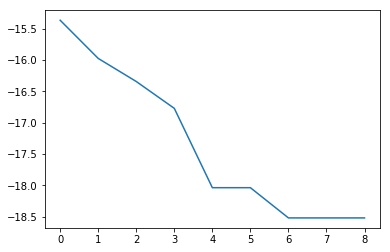

In [370]:
from matplotlib.pyplot import plot

plot(best_round_fitnesses)

In [371]:
best_round_fitnesses

[-15.367086561245404,
 -15.976190857850614,
 -16.344347595898512,
 -16.77282310230124,
 -18.038226284756075,
 -18.038226284756075,
 -18.520532772124653,
 -18.520532772124653,
 -18.520532772124653]